# Convolutional Autoencoder with K-Means

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F


# to import MNIST as torch tensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

## training and testing dataloaders

In [2]:
num_workers = 0
# how many samples per batch to load
batch_size = 100
lr = 1e-3
# how many epochs for training
num_epochs = 200

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

## autoencoder neural network design
* input layer: 1 channel, 28 pixels wide, 28 pixels long
* conv 1 layer: 16 channel, 10 pixels wide, 10 pixels long
* pool 1 layer: 16 channel, 5 pixels wide, 5 pixels long
* conv 2 layer: 32 channel, 3 pixels wide, 3 pixels long
* pool 2 layer: 32 channel, 2 pixels wide, 2 pixels long

* latent layer: 128 input, 10 output
* upscale layer: 10 input, 128 output

* deconv 3 layer: 16 channel, 5 pixels wide, 5 pixels long
* deconv 2 layer: 8 channel, 15 pixels wide, 15 pixels long
* deconv 1 layer: 1 channel, 28 pixels wide, 28 pixels long

In [3]:
class cae(nn.Module):
    def __init__(self):
        super(cae, self).__init__()
        # convolutional encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # 16, 5, 5
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 32, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # 32, 2, 2
        )
        # autoencoder bottle neck
        self.latent = nn.Sequential(
            nn.Linear(32*2*2, 10),
            #nn.Sigmoid()
        )
        self.upscale = nn.Sequential(
            nn.Linear(10, 32*2*2),
            nn.ReLU(True),
        )
        # convolutional decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2),  # 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # 1, 28, 28
            nn.Tanh()
        )
    # forward learning path
    def forward(self, x):
        x = self.encoder(x)
        x = self.latent(x.view(-1, 32*2*2))
        
        bottle_neck = F.sigmoid(x)
        x = F.tanh(x)
        
        x = self.upscale(x)
        x = self.decoder(x.view(-1, 32, 2, 2))
        return x, bottle_neck

## CAE model instantiation

In [4]:
# build a CAE model
model = cae()
# set loss function
criterion = nn.MSELoss()
# choose an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                             weight_decay=1e-7)
print(model)

cae(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (latent): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
  (upscale): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)


## training

In [5]:
# Training the model
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        # forward path
        output, _ = model(img)
        loss = criterion(output, img)
        # back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # log
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.item()))

C:\Users\Hassan\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\Hassan\Anaconda3\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch [1/200], loss:0.0439
epoch [2/200], loss:0.0351
epoch [3/200], loss:0.0313
epoch [4/200], loss:0.0294
epoch [5/200], loss:0.0282
epoch [6/200], loss:0.0275
epoch [7/200], loss:0.0269
epoch [8/200], loss:0.0264
epoch [9/200], loss:0.0262
epoch [10/200], loss:0.0259
epoch [11/200], loss:0.0257
epoch [12/200], loss:0.0255
epoch [13/200], loss:0.0253
epoch [14/200], loss:0.0251
epoch [15/200], loss:0.0250
epoch [16/200], loss:0.0249
epoch [17/200], loss:0.0247
epoch [18/200], loss:0.0245
epoch [19/200], loss:0.0244
epoch [20/200], loss:0.0243
epoch [21/200], loss:0.0241
epoch [22/200], loss:0.0240
epoch [23/200], loss:0.0238
epoch [24/200], loss:0.0237
epoch [25/200], loss:0.0236
epoch [26/200], loss:0.0235
epoch [27/200], loss:0.0234
epoch [28/200], loss:0.0233
epoch [29/200], loss:0.0233
epoch [30/200], loss:0.0232
epoch [31/200], loss:0.0231
epoch [32/200], loss:0.0230
epoch [33/200], loss:0.0229
epoch [34/200], loss:0.0228
epoch [35/200], loss:0.0227
epoch [36/200], loss:0.0227
e

## visualizing reconstructed results
### NOTE TO SELF: to be automated through DV

In [6]:
import matplotlib.pyplot as plt

dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output, _ = model(images)
# prep images for display
images = images.numpy()# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

C:\Users\Hassan\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\Hassan\Anaconda3\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


<Figure size 2500x400 with 20 Axes>

## reconstruct the entire dataset
### NOTE TO SELF: eval to be used to stop regularization

In [7]:
# run the dataset through the trained model
for image_index, data in enumerate(train_loader):
    images, itr_labels = data
    # forward pass: compute embedded outputs by passing inputs to the model
    decoded, encoded = model(images)
    if not image_index:
        #First group encoded in new array
        embedded = encoded.detach().numpy()
        #first group decoded
        disembedded = decoded.detach().numpy()
        #labels
        labels = itr_labels.detach().numpy()
        continue
    #stacking the remaining data
    embedded = np.vstack((embedded, encoded.detach().numpy()))
    disembedded = np.vstack((disembedded, decoded.detach().numpy()))
    labels = np.hstack((labels, itr_labels.detach().numpy()))

## clustering model instantiation and training

In [8]:
from sklearn.cluster import KMeans

# create a k-means model to cluster the embedded features
clustering_model = KMeans(n_clusters=10, tol = 1e-4, max_iter = 400).fit(embedded)

## visualizing results and performance evaluation

In [9]:
import import_ipynb
import DataVisuals as dv


view_results = dv.DataVisuals(disembedded.reshape(-1, 28,28), labels, clustering_model.labels_)

importing Jupyter notebook from DataVisuals.ipynb


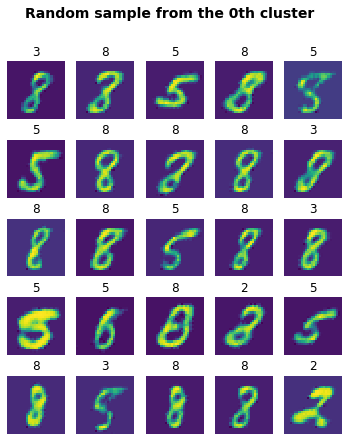

In [10]:
#view reconstructed random samples belonging to the same cluster
view_results.view_lblsample(0)

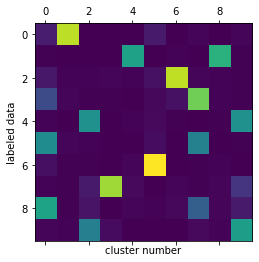

In [11]:
view_results.cm()

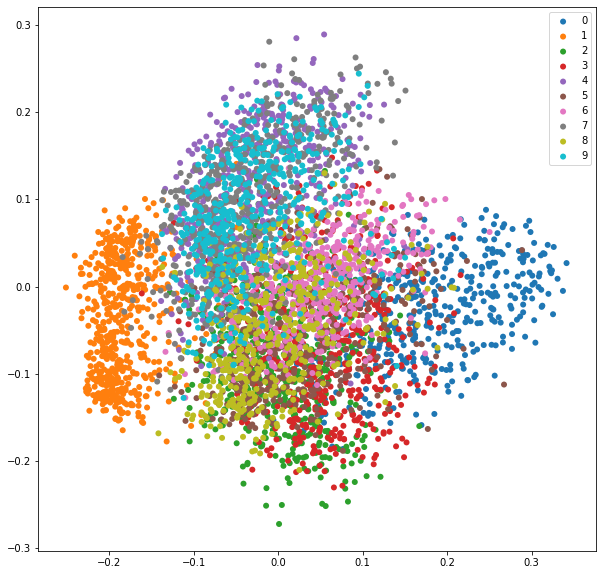

In [12]:
view_results.scat(embedded)

In [13]:
metric = dv.Metrics(labels, clustering_model.labels_)
nmi = metric.nmi()
ari = metric.ari()
acc = metric.acc()
print('NMI = {:.4f} \nARI = {:.4f} \nACC = {:.4f}'.format(nmi, ari, acc))

C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


NMI = 0.6040 
ARI = 0.4796 
ACC = 0.6124


## storing a copy of learned weights in hard drive

In [14]:
import pickle


# save the model to disk
#pickle.dump(model, open('emnistcae001.sav', 'wb'))